In [ ]:
# import libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
import random
import torch

def set_seed(seed=21):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(21)

In [ ]:
# Calving Labels in UTC
event_dict = {
    "0BD": "2023/2/11 18:30",
    "0BB": "2023/2/13 19:30",
    "09F": "2023/2/16 16:30",

    "0E7": "2023/2/23 17:30",
    "0BC": "2023/2/26 6:30",
    "12A": "2023/2/27 19:00",

    "13D": "2023/3/7 11:30",
    "0E1": "2023/3/11 19:00",
    "09B": "2023/3/13 19:30",

    "14C": "2023/3/14 2:30",
    "12B": "2023/3/22 19:30",
    "0C5": "2023/3/27 18:30",

    "0BA": "2023/4/1 19:00",
    "0BE": "2023/4/2 14:30",
    "13C": "2023/4/12 0:30"
}

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]


#********************#
# Change Required  #
#********************#
folder_path = "/content/drive/MyDrive/USDA/Calving-season-23-data/test/Final-Multi/"

file_list = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

In [ ]:
all_train = {}
all_train_time = {}

for file_name in file_list:
    file_path = os.path.join(folder_path, file_name)
    df = pd.read_csv(file_path)
    collar_id = file_name.split('.')[0][0:3]

    # drop NA and set Rounded_Time to be index
    df["KNN_Sum"] = df[[f"KNN{i+2}" for i in range(4)]].sum(axis=1)
    df["Rounded_Time"] = pd.to_datetime(df["Rounded_Time"]).dt.tz_localize(None)

    # check null
    null_values = df[['ActivityCount_Difference', 'Distance_moved', 'KNN_Sum']].isnull().any(axis=1)

    # convert values (0~1) to be 1
    df['Distance_moved'] = df['Distance_moved'].apply(lambda x: 1 if pd.notnull(x) and x < 1 else x)

    # add new features
    df['ts'] = np.where(null_values, np.nan, (df['ActivityCount_Difference'] / df['Distance_moved']) * df['KNN_Sum'])

    df.set_index('Rounded_Time', inplace=True)
    data = df[['ActivityCount_Difference', 'Distance_moved', 'KNN_Sum', 'ts']]

    # remove NA
    data.dropna(inplace=True)

    # event_label time
    label_time = pd.to_datetime(event_dict[collar_id])
    five_days_before = label_time - pd.Timedelta(days=5)
    #seven_days_after = label_time + pd.Timedelta(days=7)
    #half_month_before = label_time - pd.Timedelta(days=15)


    # Train Test split
    train = data[data.index[0]: five_days_before]
    #test = data[five_days_before: seven_days_after]
    print("Training dataset shape:", train.shape)
    # print("Test dataset shape:", test.shape)

    # remove outliers
    train_cleaned = train.copy()
    for column in ['ActivityCount_Difference', 'Distance_moved', 'KNN_Sum', 'ts']:
        train_cleaned = remove_outliers(train_cleaned, column)

    train = train_cleaned

    # normalize the data   # normalize (min-max) for each cow，later generate time series by using the same scaler (in fuction "get_test")
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(train)

#********************#
# Change Required  #
#********************#
    # Save the scaler
    scaler_filename = "/content/drive/MyDrive/USDA/FinalUpdate/min-max-scaler/" + collar_id + ".joblib"
    joblib.dump(scaler, scaler_filename)

    all_train[collar_id] = X_train
    all_train_time[collar_id] = train.index

<ipython-input-4-9eaa68ffe7f4>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


Training dataset shape: (1063, 4)


<ipython-input-4-9eaa68ffe7f4>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


Training dataset shape: (417, 4)


<ipython-input-4-9eaa68ffe7f4>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


Training dataset shape: (1085, 4)


<ipython-input-4-9eaa68ffe7f4>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


Training dataset shape: (564, 4)


<ipython-input-4-9eaa68ffe7f4>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


Training dataset shape: (829, 4)


<ipython-input-4-9eaa68ffe7f4>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


Training dataset shape: (615, 4)


<ipython-input-4-9eaa68ffe7f4>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


Training dataset shape: (421, 4)


<ipython-input-4-9eaa68ffe7f4>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


Training dataset shape: (951, 4)


<ipython-input-4-9eaa68ffe7f4>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


Training dataset shape: (704, 4)


<ipython-input-4-9eaa68ffe7f4>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


Training dataset shape: (753, 4)


<ipython-input-4-9eaa68ffe7f4>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


Training dataset shape: (532, 4)


<ipython-input-4-9eaa68ffe7f4>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


Training dataset shape: (1313, 4)


<ipython-input-4-9eaa68ffe7f4>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


Training dataset shape: (763, 4)


<ipython-input-4-9eaa68ffe7f4>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


Training dataset shape: (983, 4)
Training dataset shape: (618, 4)


<ipython-input-4-9eaa68ffe7f4>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


In [ ]:
all_train_time['14C'].shape

(485,)

In [ ]:
all_train['14C'].shape

(485, 4)

In [ ]:
import pytz

def add_time_encoding(all_train, all_train_time, timezone_str="America/Denver"):
    """
    Adding sin/cos time coding to all cow training data
    return：
        new_all_train: dict[collar_id] = ndarray(N, 6)
    """
    utc = pytz.utc
    local_tz = pytz.timezone(timezone_str)
    new_all_train = {}

    for collar_id in all_train:
        data = all_train[collar_id]  # (N, 4)
        timestamps = all_train_time[collar_id]  # (N,)

        # Convert time zones and extract "hours"
        local_times = np.array([
            utc.localize(ts).astimezone(local_tz)
            for ts in timestamps
        ])
        # time encoding (sin and cos)
        hours = np.array([t.hour + t.minute / 60 for t in local_times])
        sin_hour = np.sin(2 * np.pi * hours / 24)
        cos_hour = np.cos(2 * np.pi * hours / 24)
        time_encoding = np.stack([sin_hour, cos_hour], axis=1)  # (N, 2)

        new_data = np.concatenate([data, time_encoding], axis=1)  # (N, 6)
        new_all_train[collar_id] = new_data

    return new_all_train


In [ ]:
all_train_encoded = add_time_encoding(all_train, all_train_time)

In [ ]:
all_train_encoded['14C'].shape

(485, 6)

In [ ]:
all_train_encoded['0BA']

array([[ 0.5485348 ,  0.77201059,  0.46051042,  0.27283254, -0.70710678,
         0.70710678],
       [ 0.28663004,  0.30906098,  0.1908737 ,  0.15222572, -0.5       ,
         0.8660254 ],
       [ 0.01282051,  0.00854254,  0.18949129,  0.2223065 , -0.25881905,
         0.96592583],
       ...,
       [ 0.43589744,  0.49349976,  0.44700055,  0.3302695 ,  0.8660254 ,
        -0.5       ],
       [ 0.36080586,  0.21907714,  0.53413   ,  0.73471572,  0.70710678,
        -0.70710678],
       [ 0.40750916,  0.33089578,  0.35016148,  0.3640728 ,  0.25881905,
        -0.96592583]])

In [ ]:

# Combining data (4 features + 2 time) for all cows
all_points = np.concatenate(list(all_train_encoded.values()), axis=0)  # shape: (total_N, 6)

# convert to PyTorch TensorDataset
import torch
from torch.utils.data import DataLoader, TensorDataset

X_tensor = torch.tensor(all_points, dtype=torch.float32)
dataset = TensorDataset(X_tensor)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

# set random seed
g = torch.Generator()
g.manual_seed(21)

loader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=True,
    generator=g,
    num_workers=0
)


In [ ]:
import torch.nn as nn

class AutoEncoder(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=32):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out


In [ ]:
model = AutoEncoder()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#criterion = nn.MSELoss()
criterion = nn.L1Loss()


for epoch in range(100):
    total_loss = 0
    model.train()
    for (batch_x,) in loader:
        recon = model(batch_x)
        #loss = criterion(recon, batch_x)
        loss = criterion(recon[:, :4], batch_x[:, :4])  # time info is only used as hint, so loss only use the 4 features
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


Epoch 1, Loss: 20.5100
Epoch 2, Loss: 6.3282
Epoch 3, Loss: 2.9541
Epoch 4, Loss: 2.2099
Epoch 5, Loss: 1.7507
Epoch 6, Loss: 1.3158
Epoch 7, Loss: 1.0329
Epoch 8, Loss: 0.8574
Epoch 9, Loss: 0.7377
Epoch 10, Loss: 0.6426
Epoch 11, Loss: 0.5951
Epoch 12, Loss: 0.5800
Epoch 13, Loss: 0.4963
Epoch 14, Loss: 0.5029
Epoch 15, Loss: 0.4417
Epoch 16, Loss: 0.4165
Epoch 17, Loss: 0.4376
Epoch 18, Loss: 0.4093
Epoch 19, Loss: 0.3883
Epoch 20, Loss: 0.3557
Epoch 21, Loss: 0.3353
Epoch 22, Loss: 0.3560
Epoch 23, Loss: 0.3236
Epoch 24, Loss: 0.3754
Epoch 25, Loss: 0.3271
Epoch 26, Loss: 0.3396
Epoch 27, Loss: 0.3345
Epoch 28, Loss: 0.3025
Epoch 29, Loss: 0.2840
Epoch 30, Loss: 0.3194
Epoch 31, Loss: 0.3026
Epoch 32, Loss: 0.2761
Epoch 33, Loss: 0.3035
Epoch 34, Loss: 0.3052
Epoch 35, Loss: 0.2924
Epoch 36, Loss: 0.2978
Epoch 37, Loss: 0.2922
Epoch 38, Loss: 0.2868
Epoch 39, Loss: 0.2765
Epoch 40, Loss: 0.2772
Epoch 41, Loss: 0.3085
Epoch 42, Loss: 0.2871
Epoch 43, Loss: 0.2596
Epoch 44, Loss: 0.2

In [ ]:
"""
Save AutoEncoder model
"""
SAVE_AEMODEL = False

#********************#
# Change Required  #
#********************#
if SAVE_AEMODEL:
    torch.save(model.state_dict(), "/content/drive/MyDrive/USDA/FinalUpdate/autoencoder_stage1.pth")

In [ ]:
"""
Load AutoEncoder model
"""
LOAD_AEMODEL = True

#********************#
# Change Required  #
#********************#
if LOAD_AEMODEL:
    model = AutoEncoder()
    model.load_state_dict(torch.load("/content/drive/MyDrive/USDA/FinalUpdate/autoencoder_stage1.pth"))
    model.eval()

In [ ]:
def infer_with_mae(model, x, feature_dim=4):
    """
    x: Tensor of shape (N, 6)
    feature_dim: number of features used to get MAE (here is 4, cz the last 2 time features are not used)
    Return：
        recon: (N, 6)
        mae: (N,)
    """
    model.eval()
    with torch.no_grad():
        recon = model(x)

        # Only calculate MAE for the first feature_dim
        mae = torch.abs(recon[:, :feature_dim] - x[:, :feature_dim]).mean(dim=1)
    return recon, mae



In [ ]:
def get_test(file_name):
    collar_id = file_name.split('.')[0][0:3]

#********************#
# Change Required  #
#********************#
    # read file
    path = "/content/drive/MyDrive/USDA/Calving-season-23-data/test/Final-Multi/"
    df = pd.read_csv(path + file_name)


    # drop NA and set Rounded_Time to be index
    df["KNN_Sum"] = df[[f"KNN{i+2}" for i in range(4)]].sum(axis=1)
    df["Rounded_Time"] = pd.to_datetime(df["Rounded_Time"]).dt.tz_localize(None)

    # check null
    null_values = df[['ActivityCount_Difference', 'Distance_moved', 'KNN_Sum']].isnull().any(axis=1)

    # convert values (0~1) to be 1
    df['Distance_moved'] = df['Distance_moved'].apply(lambda x: 1 if pd.notnull(x) and x < 1 else x)

    # add new features
    df['ts'] = np.where(null_values, np.nan, (df['ActivityCount_Difference'] / df['Distance_moved']) * df['KNN_Sum'])

    df.set_index('Rounded_Time', inplace=True)
    data = df[['ActivityCount_Difference', 'Distance_moved', 'KNN_Sum', 'ts']]
    data.dropna(inplace=True)

#********************#
# Change Required  #
#********************#
    # use min-max scaler (Trained together while training Autoencoder.)
    scaler_path = "/content/drive/MyDrive/USDA/FinalUpdate/min-max-scaler/" + collar_id + ".joblib"
    scaler = joblib.load(scaler_path)
    X_test = scaler.transform(data)

    return X_test, data, df

In [ ]:
import numpy as np
import torch
import pytz

def prepare_inference_input(df, X_test, timezone_str="America/Denver"):
    """
    df: DataFrame for testset, index is UTC timestamp（pandas.Timestamp）
    X_test: numpy array (df after min-max scaling), shape = (T, 4)

    (get the above input from function "get_test", in my case: 'data' and 'X_test' from "get_test")

    Return:
        torch.Tensor of shape (T, 6)
    """
    assert len(df) == X_test.shape[0], "df and X_test are not the same length"

    # Step 1: Process timestamp, switch to local time zone
    utc = pytz.utc
    local_tz = pytz.timezone(timezone_str)
    local_times = np.array([
        utc.localize(ts).astimezone(local_tz)
        for ts in df.index
    ])

    # Step 2: Generate sin/cos time code
    hours = np.array([t.hour + t.minute / 60 for t in local_times])
    print(hours)
    sin_hour = np.sin(2 * np.pi * hours / 24)
    cos_hour = np.cos(2 * np.pi * hours / 24)
    time_encoding = np.stack([sin_hour, cos_hour], axis=1)  # shape (T, 2)

    # Merge
    X_combined = np.concatenate([X_test, time_encoding], axis=1)  # shape (T, 6)

    return torch.tensor(X_combined, dtype=torch.float32)


In [ ]:
def plot_mae_with_event(
    timestamps,
    mae,
    collar_id,
    event_dict,
    threshold=None,
    title="Reconstruction MAE over Time",
    pred=None,
    save_path=None
):
    """
    timestamps: pd.DatetimeIndex or np.array of pd.Timestamp
    mae: torch.Tensor or np.array of shape (T,)
    collar_id: current cow's collar_id (str)，for event time label in "event_dict"
    event_dict: dict[collar_id] = "YYYY/MM/DD HH:MM"
    threshold: float, optional
    pred: list of predicted timestamps (pd.Timestamp), optional
    """

    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np

    if isinstance(mae, torch.Tensor):
        mae = mae.detach().cpu().numpy()

    timestamps = pd.to_datetime(timestamps)
    T = len(mae)
    assert len(timestamps) == T, "The timestamps do not match the MAE length."

    plt.figure(figsize=(14, 4))
    plt.plot(timestamps, mae, label="MAE", color='blue')

    # y limit, make the figure clear to see. There's no need to show too high a y
    y_max = min(max(mae), mae.mean() * 20)

    # draw threshold
    if threshold is not None:
        plt.axhline(y=threshold, color='green', linestyle='--', label=f"MAE Threshold = {threshold:.4f}")
        anomaly_indices = np.where(mae > threshold)[0]
        #plt.scatter(timestamps[anomaly_indices], mae[anomaly_indices], color='green', label='Anomalies')

    # add event label
    if collar_id in event_dict:
        event_time = pd.to_datetime(event_dict[collar_id])
        plt.axvline(x=event_time, color='red', linestyle='-', linewidth=2.0, label=f"Calving Label Time: {event_time.strftime('%m/%d %H:%M')}")
        plt.text(event_time, -y_max * 0.05, f"Event", color='red', rotation=90, va='top', ha='right')

    # draw predicted points (vertical yellow lines)
    if pred is not None and len(pred) > 0:
        pred = pd.to_datetime(pred)
        for i, p in enumerate(pred):
            label = "RF Predicted Calving" if i == 0 else None  # only 1 "RF Predicted Calving" label
            plt.axvline(x=p, color='gold', linestyle='--', alpha=0.7, label=label)

    plt.xlabel("Timestamp")
    plt.ylabel("MAE")
    plt.title(title + f" (Collar {collar_id})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    plt.ylim(0, y_max)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()


In [ ]:
def save_anomaly_timestamps(
    df,
    mae,
    threshold,
    save_path,
    collar_id=None
):
    """
    save anomaly_timestamps as a CSV
    """
    import pandas as pd
    import torch

    if isinstance(mae, torch.Tensor):
        mae = mae.cpu().numpy()

    assert len(df) == len(mae), "df does not match the MAE length."

    anomaly_mask = mae > threshold
    anomaly_timestamps = df.index[anomaly_mask]

    result_df = pd.DataFrame({"timestamp": anomaly_timestamps})
    if collar_id is not None:
        result_df["collar_id"] = collar_id

    result_df.to_csv(save_path, index=False)


In [ ]:
def add_sliding_features(df):
    df = df.copy()
    windows = [6, 12]

    for feat in ['KNN2', 'KNN3', 'KNN4', 'KNN5', 'Distance_moved', 'ActivityCount_Difference']:
        for w in windows:
            df[f'{feat}_MA{w}'] = df[feat].rolling(window=w, min_periods=1).mean()
            df[f'{feat}_STD{w}'] = df[feat].rolling(window=w, min_periods=1).std()
        df[f'{feat}_Diff1'] = df[feat].diff(1)
        df[f'{feat}_Diff3'] = df[feat].diff(3)
    return df

In [ ]:
def predict_on_anomalies(df_full, anomaly_timestamps, clf):
    # df_full: ['KNN2', 'KNN3', 'KNN4', 'KNN5', 'Distance_moved', 'ActivityCount_Difference']
    df_full = add_sliding_features(df_full)

    df_full["Rounded_Time"] = pd.to_datetime(df_full["Rounded_Time"], utc=True)
    anomaly_timestamps = pd.to_datetime(anomaly_timestamps, utc=True)

    # get anomalies
    anomaly_df = df_full[df_full["Rounded_Time"].isin(anomaly_timestamps)].copy()

    features = [col for col in anomaly_df.columns if any(key in col for key in [
        'KNN', 'Distance_moved', 'ActivityCount'
    ])]

    X = anomaly_df[features].dropna()
    anomaly_df = anomaly_df.loc[X.index]

    anomaly_df["y_pred"] = clf.predict(X)

    predicted_timestamps = anomaly_df.loc[anomaly_df["y_pred"] == True, "Rounded_Time"].tolist()
    return predicted_timestamps


<ipython-input-22-4190f93c1fdd>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


[19. 20. 21. ... 16. 17. 18.]


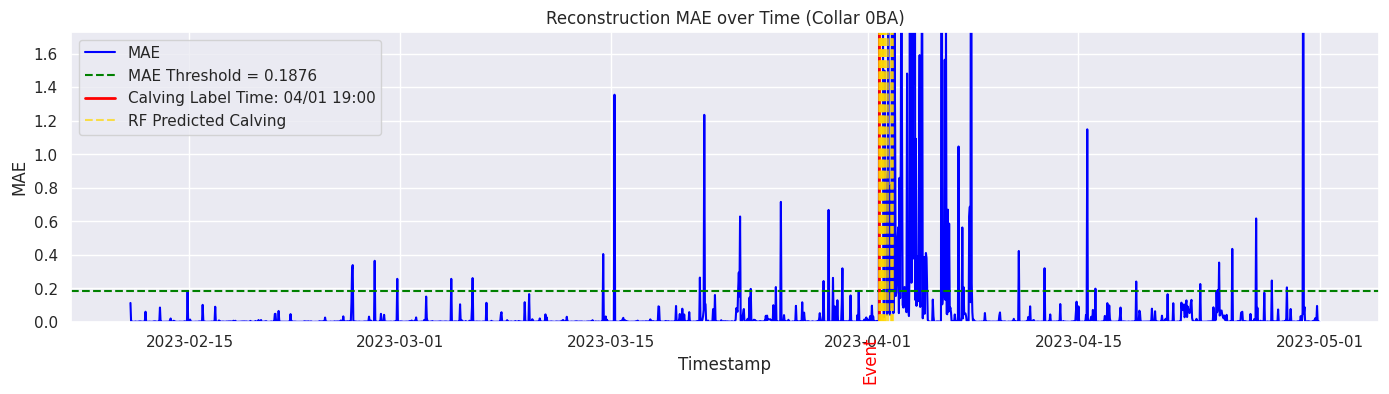

<ipython-input-22-4190f93c1fdd>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


[ 1.  2.  3. ... 16. 17. 18.]


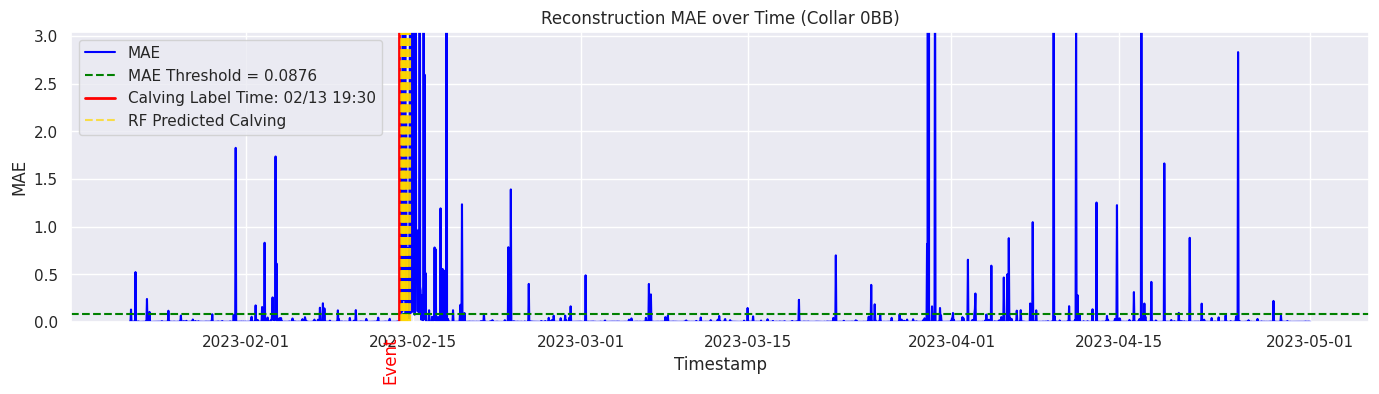

<ipython-input-22-4190f93c1fdd>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


[19. 20. 21. ... 16. 17. 18.]


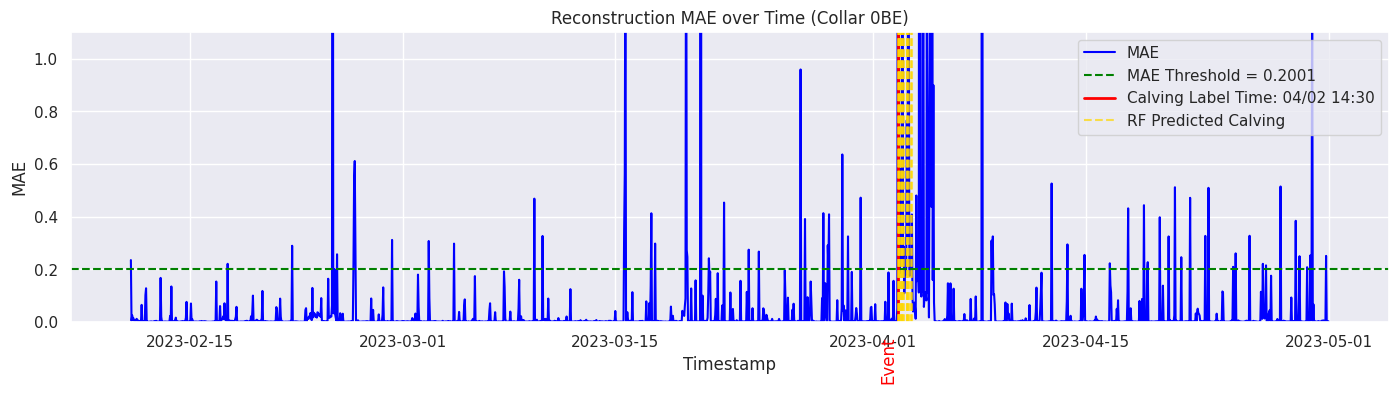

<ipython-input-22-4190f93c1fdd>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


[20. 21. 22. ... 16. 17. 18.]


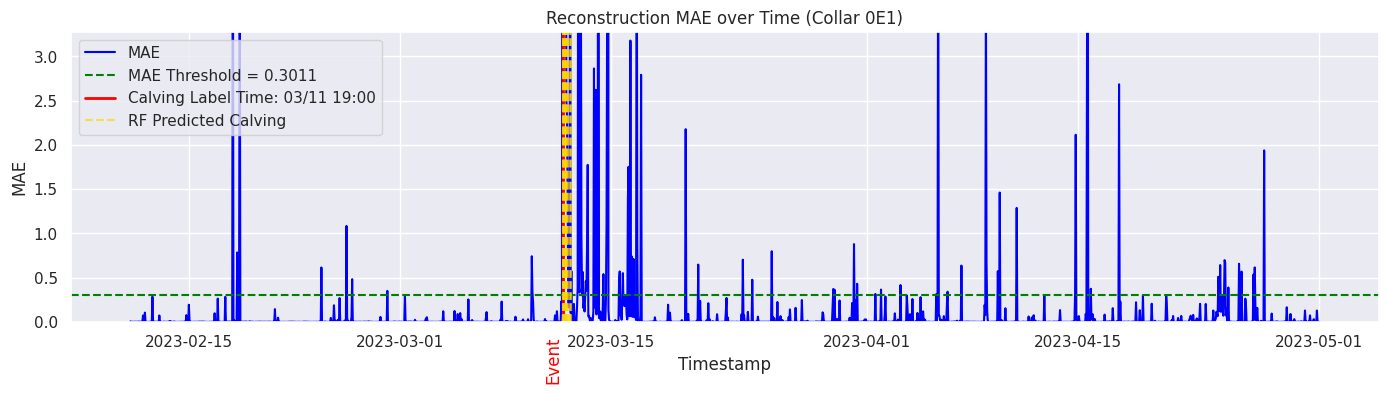

<ipython-input-22-4190f93c1fdd>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


[20. 21. 22. ... 16. 17. 18.]


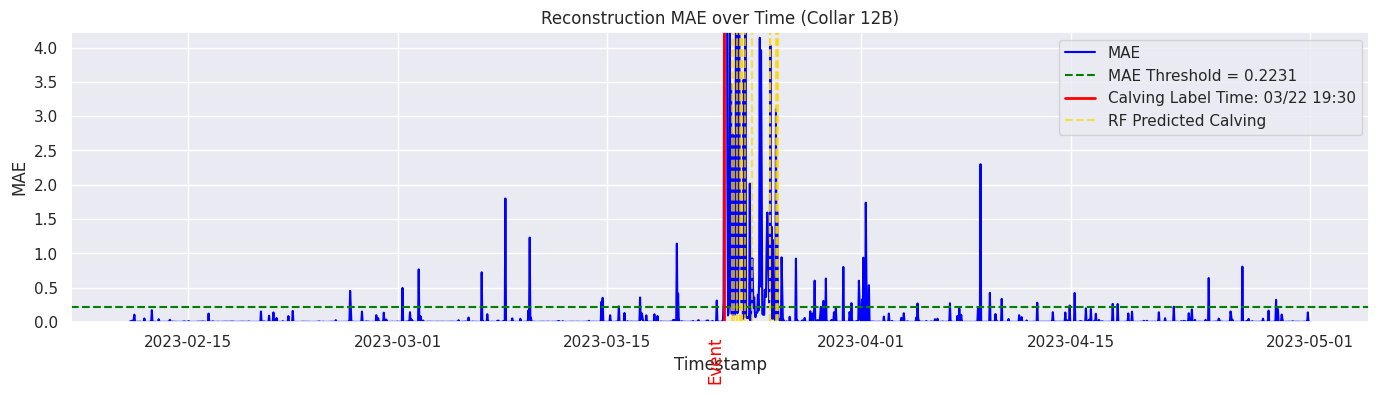

<ipython-input-22-4190f93c1fdd>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


[19. 20. 21. ... 16. 17. 18.]


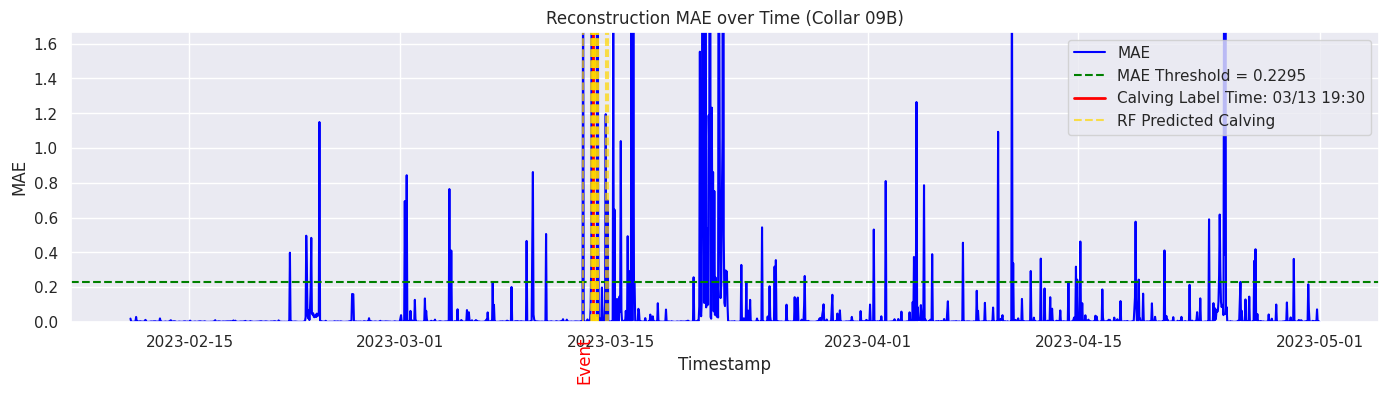

<ipython-input-22-4190f93c1fdd>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


[19. 20. 21. ... 16. 17. 18.]


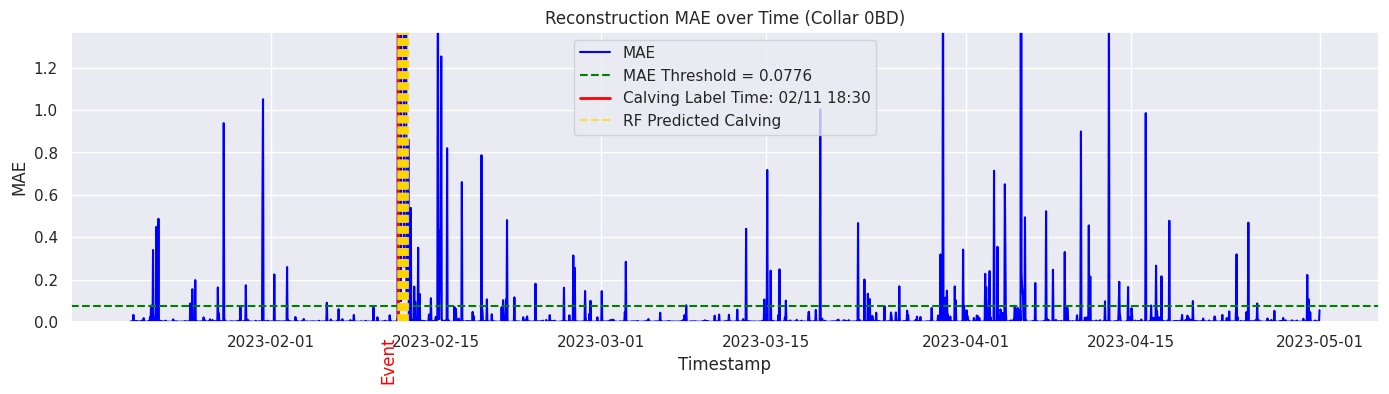

<ipython-input-22-4190f93c1fdd>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


[19. 20. 21. ... 15. 16. 17.]


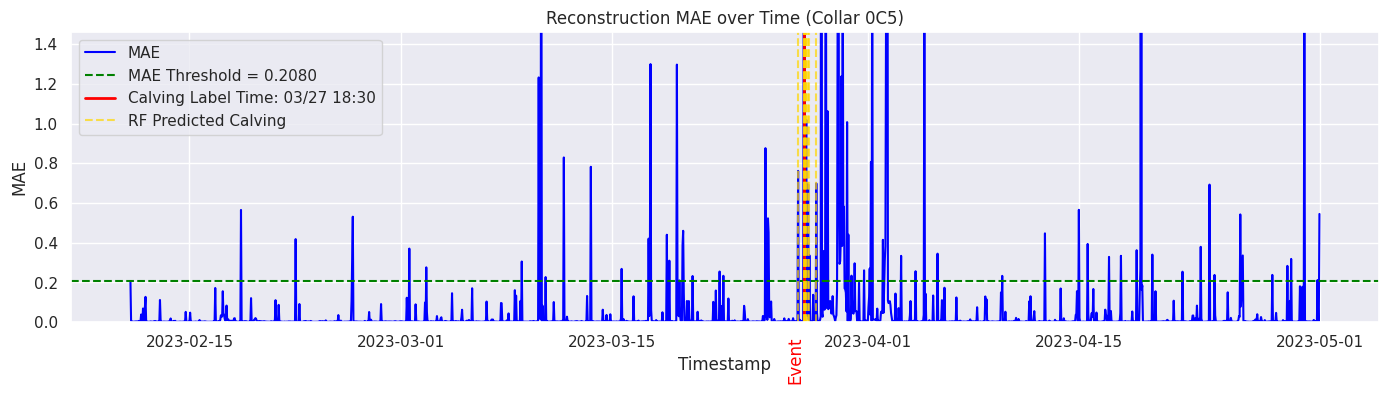

<ipython-input-22-4190f93c1fdd>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


[19. 20. 21. ... 16. 17. 18.]


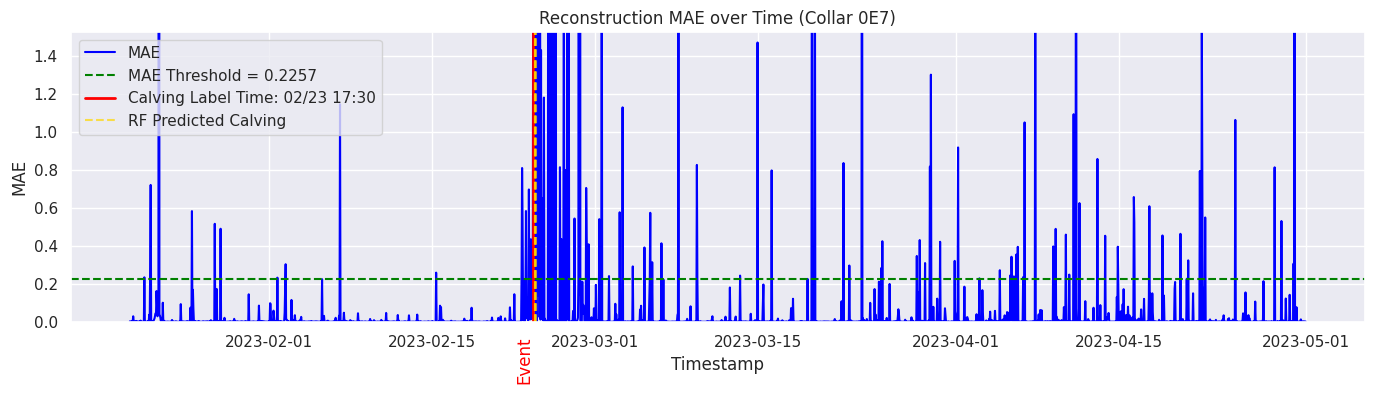

<ipython-input-22-4190f93c1fdd>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


[16. 17. 18. ... 15. 16. 17.]


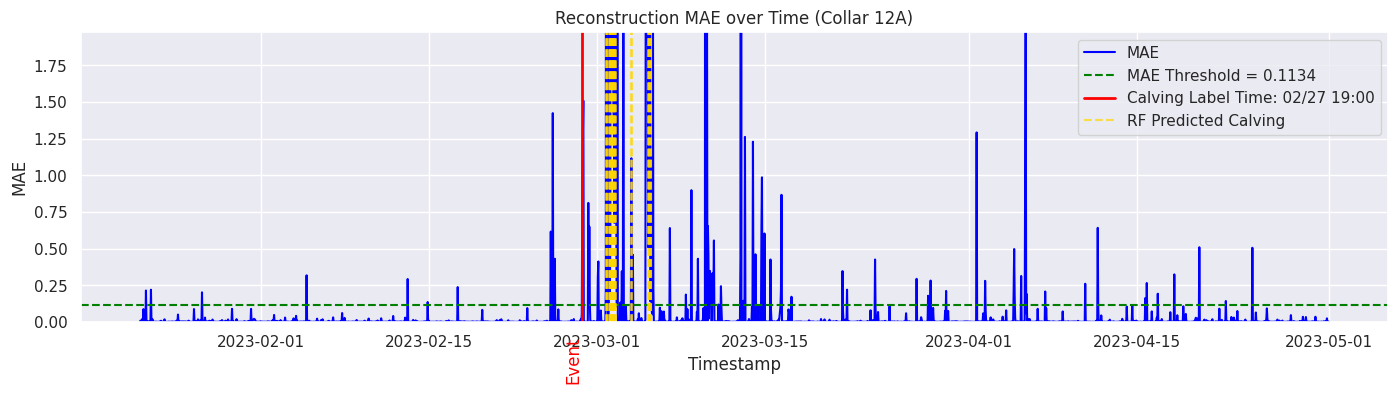

<ipython-input-22-4190f93c1fdd>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


[ 0.  1.  2. ... 16. 17. 18.]


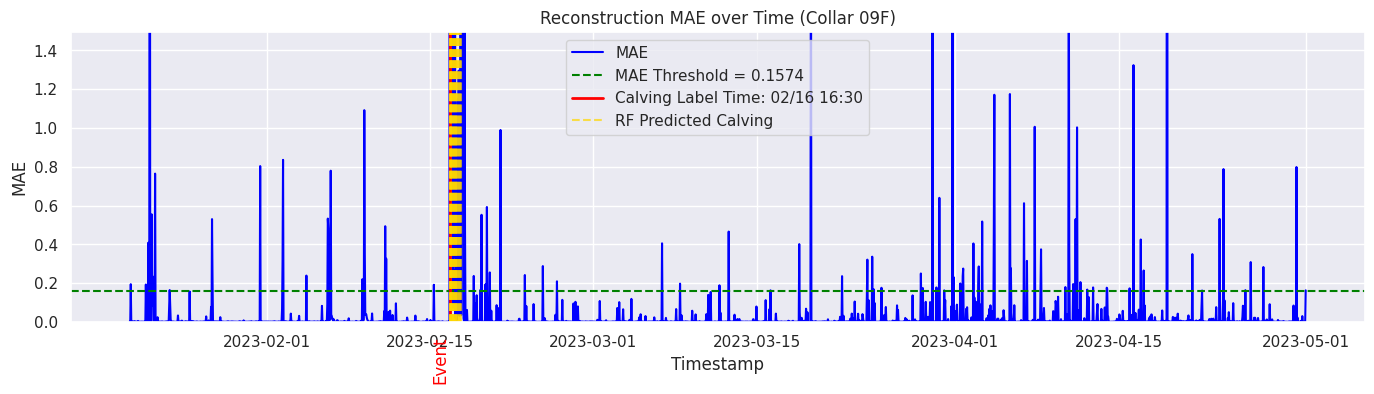

<ipython-input-22-4190f93c1fdd>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


[19. 20. 21. ... 16. 17. 18.]


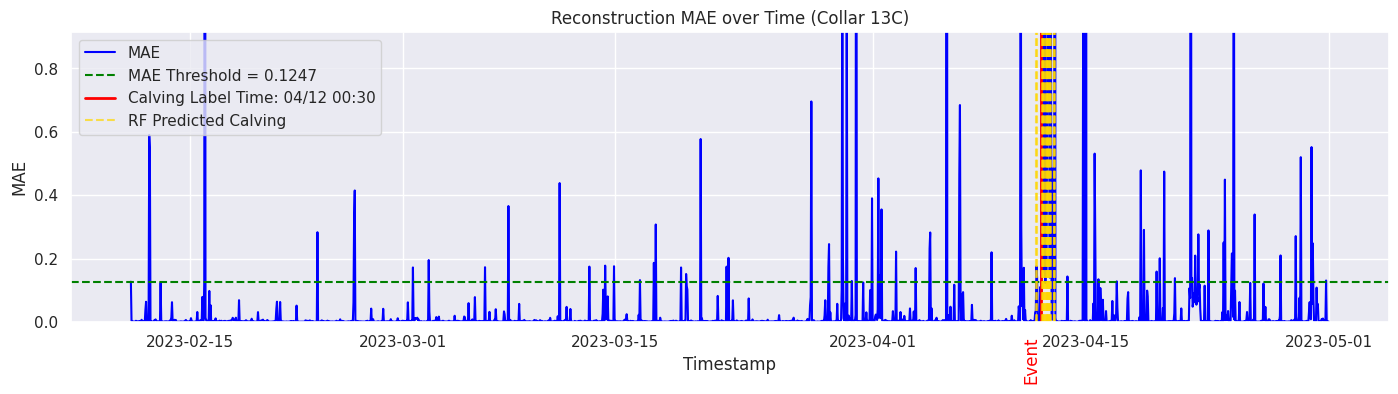

<ipython-input-22-4190f93c1fdd>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


[19. 20. 21. ... 16. 17. 18.]


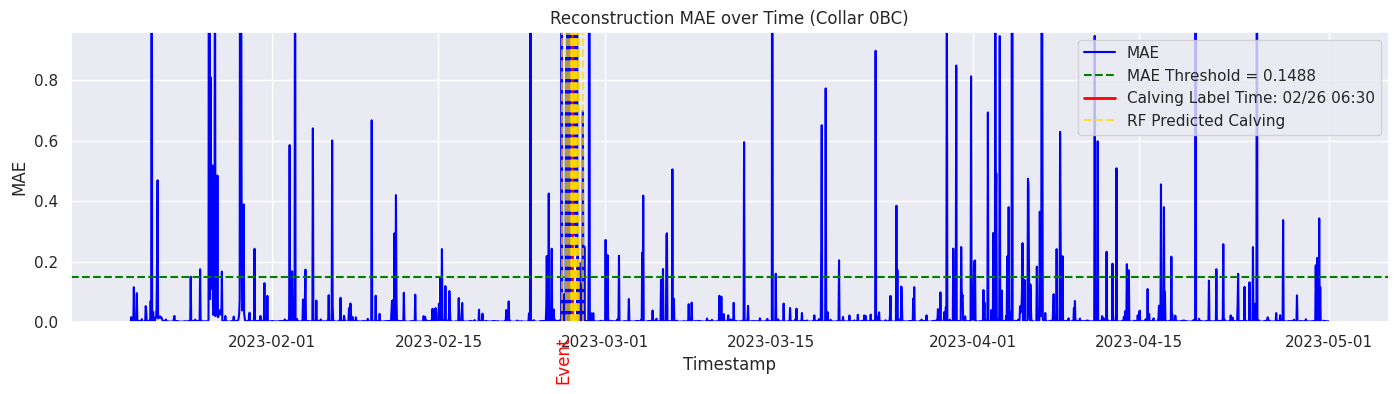

<ipython-input-22-4190f93c1fdd>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


[19. 20. 21. ... 16. 17. 18.]


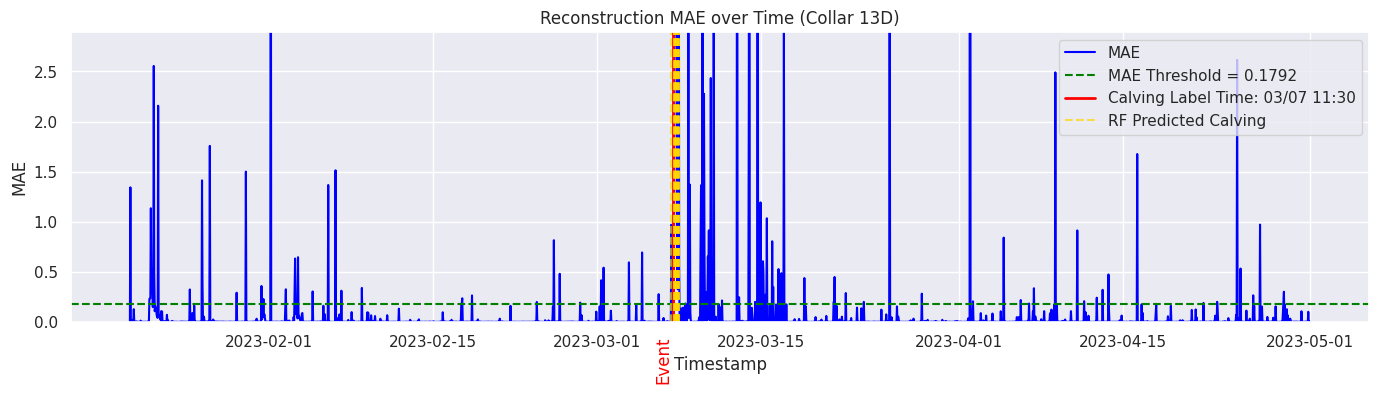

<ipython-input-22-4190f93c1fdd>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


[20. 21. 22. ... 16. 17. 18.]


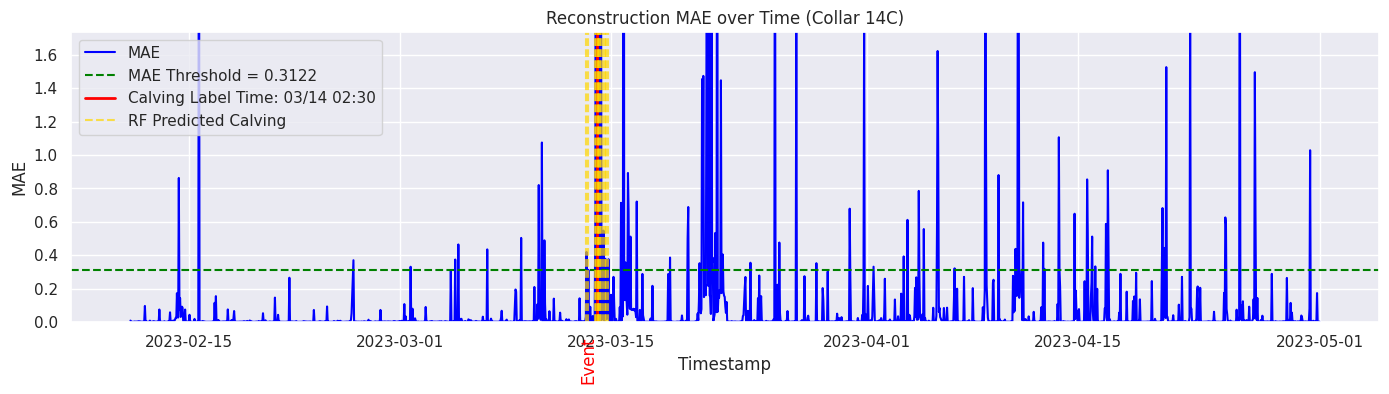

In [ ]:
#********************#
# Change Required  #
#********************#
USE_CLF = False
clf_path = '/content/drive/MyDrive/USDA/FinalUpdate/clf_models/Fold5.pkl'

#********************#
# Change Required  #
#********************#
SAVE_PLOT = False
plot_folder_path = "/content/drive/MyDrive/USDA/FinalUpdate/stage1_results/fold5/"

#********************#
# Change Required  #
#********************#
SAVE_TIMESTAMP = False
anomalies_folder_path = "/content/drive/MyDrive/USDA/FinalUpdate/anomalies_maemodel_new/"


for file_name in file_list:
    collar_id = file_name.split('.')[0][0:3]

    # read file
    df_full = pd.read_csv(folder_path + file_name)

    # get test
    X_test, data, df = get_test(file_name)

    # prepare_inference_input
    x_ready = prepare_inference_input(data, X_test)

    # infer_with_mae
    recon, mae = infer_with_mae(model, x_ready, feature_dim=4)

    # set threshold
    threshold=torch.quantile(mae, 0.95).item()

    # clf
    predicted_timestamps = None
    if USE_CLF:
        if isinstance(mae, torch.Tensor):
            list_mae = mae.cpu().numpy()
        assert len(data) == len(list_mae), "data does not match the MAE length."
        anomaly_mask = list_mae > threshold
        anomaly_timestamps = data.index[anomaly_mask]

        import joblib
        clf = joblib.load(clf_path)

        predicted_timestamps = predict_on_anomalies(df_full, anomaly_timestamps, clf)

    # plot
    if SAVE_PLOT:
        save_path = f"{plot_folder_path}st1res_{collar_id}.png"
    else:
        save_path = ''

    plot_mae_with_event(
        timestamps=data.index,
        mae=mae,
        collar_id=collar_id,
        event_dict=event_dict,
        threshold=threshold,
        pred=predicted_timestamps,
        save_path=save_path
    )

    # save timestamp
    if SAVE_TIMESTAMP:
        save_anomaly_timestamps(
            df=data,
            mae=mae,
            threshold=threshold,
            save_path=f"{anomalies_folder_path}anomalies_{collar_id}.csv",
            collar_id=collar_id
        )

